In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrand
import numpy as np
import optax
import functools # for partial
from functools import reduce
import time
from typing import List, NamedTuple

ipynb = True
dataset_name = "dictionary"
debug = False


if debug:
  jax.config.update("jax_disable_jit", True)


## LOAD DATA ##
from transformer_utils import load_dataset



prefix = ""
if ipynb == True:
  prefix = "../"

token_type = 'bpe' # wordlevel bpe charlevel
tokenizer_vocab_size = 120
if dataset_name == "shakespeare":
  dataset_path = prefix + "data/shakespeare.txt"
  vocab, train_data, test_data, encode, decode = load_dataset(dataset_path, split=0.9, vocab_size=tokenizer_vocab_size)
if dataset_name == "dnbt":
  dataset_path = prefix + "data/dnbt_posts.txt"
  vocab, train_data, test_data, encode, decode = load_dataset(dataset_path, split=0.9, vocab_size=tokenizer_vocab_size)
if dataset_name == "dictionary":
  dataset_path = prefix + "data/dictionary.txt"
  vocab, train_data, test_data, encode, decode = load_dataset(dataset_path, split=0.9, vocab_size=tokenizer_vocab_size)
if dataset_name == "wikipedia":
  dataset_path = prefix + "data/dnbt_posts.txt"
  vocab, train_data, test_data, encode, decode = load_dataset(dataset_path, split=0.9, vocab_size=tokenizer_vocab_size)
if dataset_name == "tinystories":
  print("preparing dataset...")
  dataset_path = prefix + "data/tinystories_combined.txt" # concatenate test and val, and split ourselves. should be roughly the same at 0.9
  vocab, train_data, test_data, encode, decode = load_dataset(dataset_path, split=0.9, vocab_size=tokenizer_vocab_size)
  print("Done")

vocab_size = len(vocab)



## SET UP PARAM STRUCTS ##
# https://github.com/xjdr-alt/simple_transformer/blob/main/simple_transformer.py
class BlockParams(NamedTuple):
  w_q : jax.Array
  w_k : jax.Array
  w_v : jax.Array
  w_o : jax.Array
  w1 : jax.Array
  w2 : jax.Array
  w3 : jax.Array
  attn_norm_w : jax.Array
  attn_norm_b : jax.Array
  ffnorm_w : jax.Array
  ffnorm_b : jax.Array


class ModelParams(NamedTuple):
  blocks : List[BlockParams]
  embedding_projection : jax.Array
  to_logits_w : jax.Array # after entire network
  positional_embeddings : jax.Array
  output_norm_w : jax.Array
  output_norm_b : jax.Array


def init_model_params(blocks, model_dim, d_k, qkv_dim, ff_hidden_size, vocab_size, block_size):
  D = d_k
  K = qkv_dim
  attention_heads = model_dim // d_k
  H = attention_heads
  DH = attention_heads * d_k
  scale = lambda s1, s2: 1 / jnp.sqrt(s1 + s2)
  xavier_blocks = lambda n, m: np.random.uniform(size=(blocks, n, m)) * scale(n, m)
  xavier_multihead_blocks = lambda n, m: np.random.uniform(size=(blocks, H, n, m))
  xavier = lambda n, m: np.random.uniform(size=(n, m)) * scale(n, m)
  
  block_params = BlockParams(
    # multi head attention
    # C => D, H
    w_q=xavier_multihead_blocks(D, K),
    w_k=xavier_multihead_blocks(D, K),
    w_v=xavier_multihead_blocks(D, K),
    w_o=xavier_multihead_blocks(K, D),

    w1=xavier_blocks(model_dim, ff_hidden_size),
    w2=xavier_blocks(model_dim, ff_hidden_size),
    w3=xavier_blocks(ff_hidden_size, model_dim),
    # norm stuff
    attn_norm_w=xavier_blocks(1, model_dim), # B, T, C (x) B, 1, C
    attn_norm_b=jnp.zeros(shape=(blocks, model_dim,)),
    ffnorm_w=xavier_blocks(1, model_dim),
    ffnorm_b=jnp.zeros(shape=(blocks, model_dim,)),
  )

  model_params = ModelParams(
    blocks=block_params,
    embedding_projection=xavier(vocab_size, model_dim),
    to_logits_w=xavier(model_dim, vocab_size),
    positional_embeddings=xavier(block_size, model_dim), # bias: T, C
    output_norm_w=xavier(1, model_dim),
    output_norm_b=jnp.zeros(shape=(model_dim,)),
  )

  return model_params


@functools.partial(jax.jit, static_argnames=["dropout_rate"])
def attention(block_params : BlockParams, xBTC, dropout_key, dropout_rate=0.0):
  # xBTC -> xBTHD via reshape | H = head, D = dim (like channel, but split into H segments)
  B, T, C = xBTC.shape
  H = block_params.w_q.shape[0] # attention head
  D = block_params.w_q.shape[1] # model dim after split into heads
  K = block_params.w_q.shape[2] # query dim
  BTHD = (B, T, H, D)
  xBTHD = jnp.reshape(xBTC, shape=BTHD)
  # xBTHD -> xBHTD via transpose or axes swap
  xBHTD = jnp.swapaxes(xBTHD, 1, 2)
  # xBHTD @ (Wq, Wk, Wv) => (Q, K, V)   | (B, H, T, D) @ (D, K) => (B, H, T, K) | K = query/key size. also V size here, but does not have to be.
  Q = jnp.einsum("BHTD,HDK->BHTK", xBHTD, block_params.w_q) # (B, H, T, D) @ (H, D, K) => (B, H, T, K)
  K = jnp.einsum("BHTD,HDK->BHTK", xBHTD, block_params.w_k)
  V = jnp.einsum("BHTD,HDK->BHTK", xBHTD, block_params.w_v)
  # Q @ K_transpose => QK               | (B, H, T, K) @ (B, H, K, T) => (B, H, T, T) | this may be the wrong transpose
  QK = Q @ jnp.swapaxes(K, 2, 3)
  # scale, mask, and softmax
  mask = jnp.triu(jnp.ones_like(QK), k=1) #  mask=1 where jnp.-inf will be. k=1 preseves the middle diagonal for self attention
  attention_scores = jnp.where(mask, -jnp.inf, QK/jnp.sqrt(d_k))
  # QK @ V => Z                         | (B, H, T, T) @ (B, H, T, K) => (B, H, T, K)
  Z = jax.nn.softmax(attention_scores, axis=-1) @ V # softmax in the T and K dims, for each B and H
  # Z swap axes                         | (B, H, T, K) => (B, T, H, K)
  Z = dropout(dropout_key, Z, dropout_rate)
  Z = jnp.swapaxes(Z, 1, 2)
  # Z @ w_out       | project to BTHD   | (B, T, H, K) @ (H, K, D) => (B, T, H, D)
  xBTHD = jnp.einsum("BTHK,HKD->BTHD", Z, block_params.w_o)
  # reshape to BTC                      | (B, T, H, D) => (B, T, C)
  xBTC = jnp.reshape(xBTHD, (B, T, C))
  # return xBTC_out
  xBTC = dropout(dropout_key, xBTC, dropout_rate)
  return xBTC



@functools.partial(jax.jit, static_argnames=["dropout_rate"])
def forward(dropout_key, model_params : ModelParams, xBT, vocab_size=vocab_size, dropout_rate=0.0):
  dropout_keys = jrand.split(dropout_key, 4)
  # get embeddings via projection from token onehot to channel space
  # xBT -> xBTC
  xBTOH = jax.nn.one_hot(xBT, num_classes=vocab_size, axis=-1)
  xBTC = xBTOH @ model_params.embedding_projection
  # add learned positional embeddings. broadcast over B
  B, T, C = xBTC.shape
  xBTC = xBTC + model_params.positional_embeddings[None, :T, :] # B, T, C + 1, T, C
  # scan through transformer blocks, updating xBTC
  # block
  #   attention
  #   forward projection from Z space to channel space
  # scan_fn :: (c, a) -> (c, b)
  def ffw(block_params, xBTC):
    #return jax.nn.silu(xBTC @ block_params.w1) * ((xBTC @ block_params.w2 + block_params.b2) @ block_params.w3 + block_params.b3)
    return (jax.nn.silu(xBTC @ block_params.w1) * (xBTC @ block_params.w2)) @ block_params.w3
  
  def scan_fn(xBTC, block_params):
    xBTC = xBTC + attention(block_params, layer_norm(xBTC, block_params.attn_norm_w, block_params.attn_norm_b), dropout_keys[0], dropout_rate)
    xBTC = xBTC + dropout(dropout_keys[1], ffw(block_params, layer_norm(xBTC, block_params.ffnorm_w, block_params.ffnorm_b)), dropout_rate)
    return xBTC, None # c, b
  # ((c, a) -> (c, b)) -> c -> [a] -> (c, [b]) where b is None
  xBTC = jax.lax.scan(scan_fn, xBTC, model_params.blocks)[0] # (xBTC, None) from the scan
  # then project the embeddings to logit space
  #xBTC = layer_norm(xBTC, model_params.output_norm_w, model_params.output_norm_b)
  # logits = xBTC @ model_params.to_logits_w + model_params.to_logits_b
  logits = xBTC @ model_params.to_logits_w
  return dropout(key, logits, dropout_rate)


@functools.partial(jax.jit, static_argnames=["dropout_rate"])
def model_loss(dropout_key, model_params : ModelParams, xBT, yBT, dropout_rate):
  # -sum(q*log(p))
  # dont use one hot?
  logits = forward(dropout_key, model_params, xBT, dropout_rate=dropout_rate)
  vocab_size = logits.shape[-1]
  labels = jax.nn.one_hot(yBT, num_classes=vocab_size, axis=-1)
  losses = -jnp.sum(labels * jax.nn.log_softmax(logits, axis=-1), axis=-1)
  mean_loss = jnp.mean(losses)
  return mean_loss


@functools.partial(jax.jit, static_argnames=["dropout_rate", "label_smoothing_epsilon"])
def smoothed_model_loss(dropout_key, model_params : ModelParams, xBT, yBT, dropout_rate, label_smoothing_epsilon):
  # -sum(q*log(p))
  # dont use one hot?
  logits = forward(dropout_key, model_params, xBT, dropout_rate=dropout_rate)
  vocab_size = logits.shape[-1]
  labels = jax.nn.one_hot(yBT, num_classes=vocab_size, axis=-1) * (1 - label_smoothing_epsilon) + label_smoothing_epsilon/vocab_size
  losses = -jnp.sum(labels * jax.nn.log_softmax(logits, axis=-1), axis=-1)
  mean_loss = jnp.mean(losses)
  return mean_loss


# for validation only
@jax.jit
def model_loss_and_accuracy(model_params : ModelParams, xBT, yBT):
  # -sum(q*log(p))
  # dont use one hot?
  dropout_key = jrand.PRNGKey(0) # not used, but needed
  logits = forward(dropout_key, model_params, xBT) # no key, no dropout
  vocab_size = logits.shape[-1]
  labels = jax.nn.one_hot(yBT, num_classes=vocab_size, axis=-1)
  losses = -jnp.sum(labels * jax.nn.log_softmax(logits, axis=-1), axis=-1) # no label smoothing
  mean_loss = jnp.mean(losses)
  mean_accuracy = jnp.mean(yBT == jnp.argmax(logits, axis=-1))
  return mean_loss, mean_accuracy


@functools.partial(jax.jit, static_argnames=['optimizer', "dropout_rate", "label_smoothing_epsilon"])
def train_step(dropout_key,
               model_params:ModelParams,
               xBT, yBT,
               opt_state, optimizer,
               dropout_rate, label_smoothing_epsilon):
  # jax value and grad
  loss, grads = jax.value_and_grad(smoothed_model_loss, argnums=1)(
    dropout_key, model_params, xBT, yBT, dropout_rate, label_smoothing_epsilon)
  # update optimizer
  updates, opt_state = optimizer.update(grads, opt_state, model_params)
  # update params
  model_params = optax.apply_updates(updates, model_params)
  # return opt state, loss, and new params
  return model_params, opt_state, loss, grads


@jax.jit
def inference(model_params : ModelParams, xBT, temp=0.5):
  dropout_key = jrand.PRNGKey(0) # not used
  logits = forward(dropout_key, model_params, xBT, dropout_rate=0.0)[0, :, :] # the first Batch
  probs = jax.nn.softmax(logits / temp, axis=-1)
  get_token = lambda channel: jrand.choice(jrand.PRNGKey(int(1000*time.time())), channel.shape[-1], p=channel)
  ts = jax.vmap(get_token, in_axes=0, out_axes=0)(probs) # just take the first T in the first batch ig
  return ts


@functools.partial(jax.jit, static_argnames=["dropout_rate"])
def dropout(dropout_key, tensor, dropout_rate):
  if dropout_rate == 0:
    return tensor
  # generate dropout_mask = rand(x) < dropout_rate of size tensor.shape
  dropout_mask = jrand.uniform(dropout_key, tensor.shape, tensor.dtype) <= dropout_rate
  return jnp.where(dropout_mask, 0, tensor) * (1 / (1 - dropout_rate))


@jax.jit
def layer_norm(BTC, w, b):
  # norm over TxC
  epsilon = 1e-7
  mean = jnp.mean(BTC, axis=(1, 2), keepdims=True)
  variance = jnp.var(BTC, axis=(1, 2), keepdims=True)
  normalized = (BTC - mean) / jnp.sqrt(variance + epsilon)
  return normalized * w + b


@jax.jit
def channel_norm(BTC, w, b):
  # norm over C
  epsilon = 1e-7
  mean = jnp.mean(BTC, axis=-1, keepdims=True)
  variance = jnp.var(BTC, axis=-1, keepdims=True)
  normalized = (BTC - mean) / jnp.sqrt(variance + epsilon)
  return normalized * w + b




## TRAIN
# model params
# model params
transformer_blocks = 6
attention_heads = 8

model_dim = 512
qkv_dim = 64
ff_hidden_size = 2048 # 2048
block_size = 64 # xlen


# paper lr stuff
warmup_steps = 4000
get_lr = lambda step_num: (model_dim**-0.5) * min(step_num ** -0.5, step_num * warmup_steps**(-1.5))
initial_lr = get_lr(1)
label_smoothing_epsilon = 0.1
dropout_rate = 0.1

# adam
beta1 = 0.9
beta2 = 0.98
eps = 1e-9


# set up training
epochs = 10000
max_shifts = 1000000000000000000
train_batch_size = 64
test_batch_size = 16
print_every = 100
stop_if_above = 1.5 # 150% of min val loss


continue_training = False
start_ep = 100
start_step = 17600

d_k = model_dim // attention_heads

if not continue_training:
  model_params = init_model_params(transformer_blocks, model_dim, d_k, qkv_dim, ff_hidden_size, vocab_size, block_size) # t blocks is hardcoded to 1 atm
  optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=initial_lr, b1=beta1, b2=beta2, eps=eps)
  opt_state = optimizer.init(model_params)
  print("model params initialized.\nstarting training")



loss_tracker = []
global_step = 1
min_val_loss = 10000 # init min val loss as extremely high
stop_training = False # flag to stop training
for epoch in range(epochs):
  if stop_training:
    break
  if continue_training and epoch < start_ep:
    continue
  tokens_per_shift = (block_size + 1)*train_batch_size
  test_tokens_per_shift = (block_size + 1)*test_batch_size
  shifts = len(train_data) - tokens_per_shift
  test_shifts = len(test_data) - test_tokens_per_shift

  local_step = 1
  losses = []

  for shift in range(0, min(shifts, max_shifts), tokens_per_shift):
    global_step += 1
    local_step += 1
    if continue_training and global_step < start_step:
      continue
    steps_start = time.time()

    # update LR
    opt_state.hyperparams['learning_rate'] = get_lr(global_step)

    # gather data and train
    train_tokens = train_data[shift:shift + tokens_per_shift].reshape(-1, block_size + 1) # (B, T) where T = block_size
    xBT = train_tokens[:, :block_size] # get up to prompt_length
    yBT = train_tokens[:, 1:block_size+1] # get the one after prompt_length
    key = jrand.PRNGKey(epoch*shifts + shift)
    model_params, opt_state, loss, grads = train_step(key, model_params, xBT, yBT, opt_state, optimizer, dropout_rate, label_smoothing_epsilon)

    # tracking
    losses.append(loss)
    loss_tracker.append(("train", epoch, global_step, float(loss)))
    if global_step % print_every == 0 or global_step == 0:
      # validation
      test_shift = shift % test_shifts
      test_tokens = test_data[test_shift:test_shift + test_tokens_per_shift].reshape(-1, block_size + 1)
      test_xBT = test_tokens[:, :block_size]
      test_yBT = test_tokens[:, 1:block_size+1]
      test_loss, test_accuracy = model_loss_and_accuracy(model_params, test_xBT, test_yBT)
      loss_tracker.append(("test", epoch, global_step, float(test_loss)))
      
      # tracking
      yhats = inference(model_params, xBT, temp=0.5)
      in_chars = decode(test_xBT[0]).replace('\n', '↵')
      target_char = decode(test_yBT[0]).replace('\n', '↵')
      pred_char = decode(yhats).replace('\n', '↵')
      mean_step_loss = jnp.mean(jnp.array(losses))
      steps_stop = time.time()
      steps_per_second = local_step / (steps_stop - steps_start)
      samples_per_second = steps_per_second
      lr = opt_state.hyperparams['learning_rate'] 
      print(f"e/s={epoch}/{global_step} samples/s={samples_per_second:0.0f} {lr=:0.5f} tloss={mean_step_loss:0.3f} vloss/acc={test_loss:0.3f}/{100*test_accuracy:0.1f}% "
            f"|| val \n'...{target_char}' =?> \n'...{pred_char}'")
      losses = []
      local_step = 0

      # stopping
      if test_loss > stop_if_above * min_val_loss:
        stop_training = True
        break
      else:
        min_val_loss = min(test_loss, min_val_loss)


Loading BPE vocab and data from dictionary_vocab_120.bpe...
Sample Input: ad or front of. 2 be in charge of. 3 provide with a head or 
Tokenized: [29, 74, 56, 113, 56, 33, 73, 116, 42, 56, 22, 33, 109, 96, 56, 10, 111, 110, 56, 36, 81, 29, 73, 53, 111, 22, 33, 109, 8, 56, 18, 73, 22, 91, 32, 74, 111, 101, 32, 42, 81, 112, 56, 81, 50, 29, 74, 56, 113, 56]
Decoded: ad or front of. 2 be in charge of. 3 provide with a head or 


/home/dan/Desktop/ai_gym/.venv/lib/python3.10/site-packages/optax/schedules/_inject.py:34: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.asarray(x, dtype=dtype)


model params initialized.
starting training


KeyboardInterrupt: 

In [3]:
# stats and norms
from pprint import pprint

def pprint_namedtuple(nt):
  nt = nt._replace(blocks=dict(nt.blocks._asdict()))
  pprint(dict(nt._asdict()))
  print()


parameter_shapes_and_counts = jax.tree_util.tree_map(lambda t: f"{t.shape} => {t.size}", grads)
parameter_count = jax.tree_util.tree_map(lambda t: t.size, grads)
parameter_total = jax.tree.reduce(lambda a, b: a + b, parameter_count)
print(f"Parameters: {parameter_total:,}")
pprint_namedtuple(parameter_shapes_and_counts)


print("Grad norms:")
grad_norms = jax.tree_util.tree_map(jnp.linalg.norm, grads)
pprint_namedtuple(grad_norms)
print()

Parameters: 19,829,760
{'blocks': {'attn_norm_b': '(6, 512) => 3072',
            'attn_norm_w': '(6, 1, 512) => 3072',
            'ffnorm_b': '(6, 512) => 3072',
            'ffnorm_w': '(6, 1, 512) => 3072',
            'w1': '(6, 512, 2048) => 6291456',
            'w2': '(6, 512, 2048) => 6291456',
            'w3': '(6, 2048, 512) => 6291456',
            'w_k': '(6, 8, 64, 64) => 196608',
            'w_o': '(6, 8, 64, 64) => 196608',
            'w_q': '(6, 8, 64, 64) => 196608',
            'w_v': '(6, 8, 64, 64) => 196608'},
 'embedding_projection': '(120, 512) => 61440',
 'output_norm_b': '(512,) => 512',
 'output_norm_w': '(1, 512) => 512',
 'positional_embeddings': '(64, 512) => 32768',
 'to_logits_w': '(512, 120) => 61440'}

Grad norms:
{'blocks': {'attn_norm_b': Array(7.6341777, dtype=float32),
            'attn_norm_w': Array(7.3618927, dtype=float32),
            'ffnorm_b': Array(1.1517551, dtype=float32),
            'ffnorm_w': Array(0.66483, dtype=float32),
       

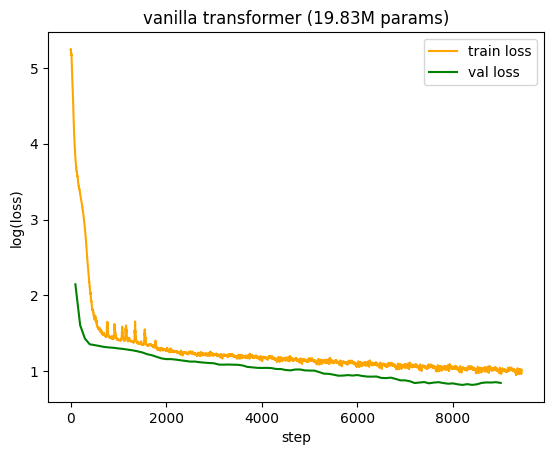

In [4]:
from matplotlib import pyplot as plt
loss_tracker = [item for item in loss_tracker if type(item) == type((2,))]
steps_per_epoch = 0
for item in loss_tracker:
  if item[2] > steps_per_epoch:
    steps_per_epoch = item[2]


def moving_average(xs, ys, window):
  queue = []
  mays = []
  for elem in ys:
    if len(queue) < window:
      queue.append(elem)
    if len(queue) < window:
      continue
    elif len(queue) == window:
      mays.append(sum(queue)/window)
      queue.pop(0)
      queue.append(elem)
  
  return xs[:-window + 1], mays


trainx, trainy = zip(*[(step, loss) for losstype, epoch, step, loss in loss_tracker if losstype=="train"])
window_size = 5 # steps
trainx, trainy = moving_average(trainx, trainy, window_size)
testx, testy = zip(*[(step, loss) for losstype, epoch, step, loss in loss_tracker if losstype=="test" ])
testx, testy = moving_average(testx, testy, window_size)

plt.title(f'vanilla transformer ({parameter_total/1_000_000:0.2f}M params)')
plt.plot(trainx, jnp.log(jnp.array(trainy)), c='orange', label='train loss')
plt.plot(testx, jnp.log(jnp.array(testy)), c='green', label='val loss')
plt.xlabel('step')
plt.ylabel('log(loss)')
plt.legend()
plt.show()

In [8]:
prompt = """Abbacy  n. (pl. -ies) office or jurisdiction of an abbot or abbess. [latin: related to *abbot]

Meep  n. """
temp = 0.4

@jax.jit
def inference(model_params : ModelParams, xBT, temp=0.5):
  key = jrand.PRNGKey(0)
  logits = forward(key, model_params, xBT)[0, :, :] # the first Batch
  probs = jax.nn.softmax(logits / temp, axis=-1)
  get_token = lambda channel: jrand.choice(jrand.PRNGKey(int(1000*time.time())), channel.shape[-1], p=channel)
  ts = jax.vmap(get_token, in_axes=0, out_axes=0)(probs) # just take the first T in the first batch ig
  return ts


print(len(prompt))
import time
key = jrand.PRNGKey(int(100*time.time()))
completion = []

token_prompt = encode(prompt)

print(decode(token_prompt), end='')
for i in range(1000):
  token_prompt = encode(prompt)
  context = token_prompt[-block_size:]
  xBT = jnp.array(context)[None, :] # fake batch of 1
  next_token = decode([inference(model_params, xBT, temp=temp)[-1]])
  print(next_token, end='')
  prompt += next_token

105
Abbacy  n. (pl. -ies) office or jurisdiction of an abbot or abbess. [latin: related to *abbot]

Meep  n. & ferobefor[french from latin juial  —adj. 1 not with a feroslang foetus jelly. 3 not not suffer (a spanism n. [obsolete a kind of jumble nounrica kind of junfemine.  fulzola navine.  felly]

Fulzine, french jumble]

Fuluijumble]

Fulzle]

Fulzle]

Fulzijejiralain]

Jejungi  n. (pl. -a]

Jula]

Jula: related to *nakulate  —adj. 1 jule peoplal, *jumbola]

Fulary n. [latin guulary]

Fule. [jumbola guulary gu guulary]

Jumbulzel  v. (- jumbulzor  n. (brituguuuuuuuuuuuuuuuuuuuer]

Linesaduuer]

Lummau  n. (pl. Jamuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu

KeyboardInterrupt: 

In [14]:
from matplotlib import pyplot as plt

plt.plot(*zip(*enumerate(mean_step_loss)))
plt.show()

TypeError: iteration over a 0-d array

In [3]:
"abc"[:3]

'abc'

In [109]:
import pickle

model_path = 'weights.pickle'

with open(model_path, 'wb') as file:
  pickle.dump(model_params, file)

In [110]:
with open(model_path, 'rb') as file:
  model_params_pickle = pickle.load(file)